# BAIT508_Industry_Analysis
David Chen (30409156)
Wanting Xu (81971392)

## Part 1. Quantitative Analysis of the Industry Sector

In [2]:
# Package Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import warnings

from nltk.corpus import stopwords
nltk.download('stopwords')

warnings.filterwarnings('ignore')

#Load the data of major industry sectors and their corresponding codes
dataFrameMajorGroup = pd.read_csv('data/major_groups.csv')

dataFrame10K = pd.read_csv('data/2020_10K_item1_full.csv')

dataFramePublicFirms = pd.read_csv('data/public_firms.csv')

print(dataFrameMajorGroup.head())
print(dataFramePublicFirms.head())
print(dataFrame10K.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   major_group                                        description
0            1                      Agricultural Production Crops
1            2  Agriculture production livestock and animal sp...
2            7                              Agricultural Services
3            8                                           Forestry
4            9                       Fishing hunting and trapping
   gvkey  fyear location      conm     ipodate   sic  prcc_c      ch      ni  \
0   1004   1994      USA  AAR CORP  1988/01/01  5080  13.375  22.487  10.463   
1   1004   1995      USA  AAR CORP  1988/01/01  5080  22.000  33.606  16.012   
2   1004   1996      USA  AAR CORP  1988/01/01  5080  30.250  51.705  23.025   
3   1004   1997      USA  AAR CORP  1988/01/01  5080  38.750  17.222  35.657   
4   1004   1998      USA  AAR CORP  1988/01/01  5080  23.875   8.250  41.671   

     asset     sale       roa  
0  425.814  451.395  0.024572  
1  437.846  504.990  0.036570  
2  529.584  589.328  0.0434

### A. Industry Sector Selection and Data Filtering

#### 1. 
List of major industry sectors and their corresponding codes has been loaded as dataframe `dataFrameMajorGroup`. Among the major industries listed we propose to look into [Industry Name]

In [236]:
selectedMajorGroupCode = 51

#### 2.

In [237]:
# Filter the data in "data/public_firms.csv" to only include the firms belonging to the industry sector(s) you have selected.
def filterByIndustry(dataFrame, majorGroupCode):
    return dataFrame[dataFrame['sic']//100 == majorGroupCode]

filteredPublicFirms = filterByIndustry(dataFramePublicFirms, selectedMajorGroupCode)

print(filteredPublicFirms)

         gvkey  fyear location                      conm ipodate   sic  \
368       1094   1995      USA                ACETO CORP     NaN  5160   
369       1094   1996      USA                ACETO CORP     NaN  5160   
370       1094   1997      USA                ACETO CORP     NaN  5160   
371       1094   1998      USA                ACETO CORP     NaN  5160   
372       1094   1999      USA                ACETO CORP     NaN  5160   
...        ...    ...      ...                       ...     ...   ...   
207716  264393   2016      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   
207717  264393   2017      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   
207718  264393   2018      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   
207719  264393   2019      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   
207720  264393   2020      USA  INNOVATIVE FOOD HOLDINGS     NaN  5140   

        prcc_c     ch     ni   asset     sale       roa  
368     16.000  1.644  7.756  86.116  164.783  0.0900

#### 3.

In [238]:
#a.How many unique firm-year ("fyear") observations are there in the filtered dataset?
numFyear =len(filteredPublicFirms.groupby('fyear'))

print(f'There are {numFyear} unique firm-year ("fyear") observations in the filtered dataset')

There are 27 unique firm-year ("fyear") observations in the filtered dataset


In [239]:
# b.How many unique firms are there in the filtered dataset?
numUniqueFirms = len(filteredPublicFirms.groupby('gvkey'))
print(f'There are {numUniqueFirms} unique firms in the filtered dataset')

There are 277 unique firms in the filtered dataset


In [240]:
# c. How many firms in the filtered dataset have records over all 27 years (1994-2020)?
gvKeyYear = filteredPublicFirms.groupby('gvkey').count()[['fyear']]

numFirmsRecordesAllYears = len(gvKeyYear[gvKeyYear['fyear'] == 27])

print(f'There are {numFirmsRecordesAllYears} firms in the filtered dataset have records over all 27 years (1994-2020)')


There are 4 firms in the filtered dataset have records over all 27 years (1994-2020)


### B. Preliminary Analysis

In [241]:
def topFirms(column, numFirms, fy = 0):
    if fy == 0:
        dataFrame = filteredPublicFirms
    else:
        dataFrame = filteredPublicFirms[filteredPublicFirms['fyear'] == fy]
    return dataFrame.sort_values(by=column, ascending=False).head(numFirms)

In [242]:
#1.	What are the top 10 firms with the highest stock price (column "prcc_c") in the year 2020?
topFirms('prcc_c', 10, 2020)

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
24707,7171,2020,USA,MCKESSON CORP,NaN,5122,173.92,6278.000,-4539.000,65015.000,238228.000,-0.069815
119266,61122,2020,USA,AMCON DISTRIBUTING CO,1995/08/04,5190,118.95,0.661,5.543,188.001,1127.979,0.029484
112130,31673,2020,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,97.76,4597.746,-3408.716,44274.830,189893.926,-0.076990
37549,10247,2020,USA,SYSCO CORP,NaN,5140,74.26,6059.427,215.475,22628.266,52893.310,0.009522
175383,147708,2020,USA,CALAVO GROWERS INC,NaN,5140,69.43,4.055,-13.625,429.624,1059.371,-0.031714
6848,2751,2020,USA,CARDINAL HEALTH INC,NaN,5122,53.56,2771.000,-3696.000,40766.000,152922.000,-0.090664
17958,5530,2020,USA,HAWKINS INC,NaN,5160,52.31,2.998,40.980,472.550,596.871,0.086721
40945,11017,2020,USA,UNIVERSAL CORP/VA,NaN,5150,48.61,197.221,87.410,2341.924,1983.357,0.037324
55415,14269,2020,USA,HERBALIFE NUTRITION LTD,NaN,5122,48.05,1045.400,372.600,3076.100,5541.800,0.121127
98338,28787,2020,USA,PERFORMANCE FOOD GROUP CO,1993/08/24,5140,47.61,420.700,-114.100,7719.700,25086.300,-0.014780


In [243]:
#2.	What are the top 10 firms with the highest sales (column "sale") in the entire history of the dataset?
topFirms('sale', 10)

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
24707,7171,2020,USA,MCKESSON CORP,NaN,5122,173.92,6278.000,-4539.000,65015.000,238228.000,-0.069815
24706,7171,2019,USA,MCKESSON CORP,NaN,5122,138.32,NaN,900.000,61247.000,231051.000,0.014695
24705,7171,2018,USA,MCKESSON CORP,NaN,5122,110.47,2981.000,34.000,59672.000,214319.000,0.000570
24704,7171,2017,USA,MCKESSON CORP,NaN,5122,155.95,2672.000,67.000,60381.000,208357.000,0.001110
24703,7171,2016,USA,MCKESSON CORP,NaN,5122,140.45,NaN,5070.000,60969.000,198533.000,0.083157
24702,7171,2015,USA,MCKESSON CORP,NaN,5122,197.23,NaN,2258.000,56563.000,190884.000,0.039920
112130,31673,2020,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,97.76,4597.746,-3408.716,44274.830,189893.926,-0.076990
112129,31673,2019,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,85.02,3374.194,855.365,39171.980,179589.121,0.021836
24701,7171,2014,USA,MCKESSON CORP,NaN,5122,207.58,5341.000,1476.000,53870.000,179045.000,0.027399
112128,31673,2018,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,74.40,2492.516,1658.405,37669.838,167939.635,0.044025


In [244]:
#3.	What is the geographical distribution (column "location") of all the firms? In other words, how many firms are there in each location? Please list the top 10 locations. 
topLocations = filteredPublicFirms.groupby('location')[['gvkey']].count().sort_values(by='gvkey', ascending=False).head(10)
topLocations

,gvkey
location,
USA,2086
CHN,48
ISR,42
HKG,38
BRA,38
GBR,29
MEX,17
RUS,17
CHE,12


<Axes: xlabel='fyear'>

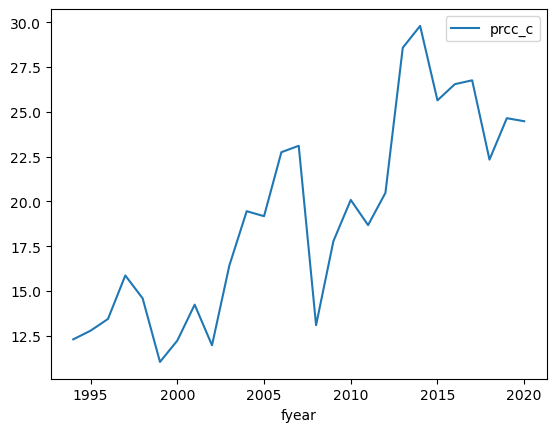

In [245]:
#4.	Create a line chart to show the average stock price (column "prcc_c") in the selected sector(s) across the years. If you have selected multiple sectors, draw multiple lines to show them separately.
meanStockPrice = filteredPublicFirms.groupby('fyear')[['prcc_c']].mean()
meanStockPrice.plot.line()

In [392]:
#5.	Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?
# ideation by ChatGPT

df_2007 = filteredPublicFirms[filteredPublicFirms['fyear'] == 2007]
df_2008 = filteredPublicFirms[filteredPublicFirms['fyear'] == 2008]

avg_price_2007 = df_2007.groupby('gvkey')['prcc_c'].mean()
avg_price_2008 = df_2008.groupby('gvkey')['prcc_c'].mean()

percentage_drop = ((avg_price_2008 - avg_price_2007) / avg_price_2007) * 100

most_affexted_gvkey = percentage_drop.idxmin()
most_affected_conm = df_2008[df_2008['gvkey'] == most_affexted_gvkey]['conm'].values[0]
max_drop = abs(percentage_drop.min())

print(f"The firm most affected by the 2008 Financial Crisis is {most_affected_conm} (gvkey: {most_affexted_gvkey}) with a drop of {max_drop}%.")

The firm most affected by the 2008 Financial Crisis is CENTRAL ENERGY PARTNERS LP (gvkey: 161977) with a drop of 92.70588235294117%.


<Axes: xlabel='fyear'>

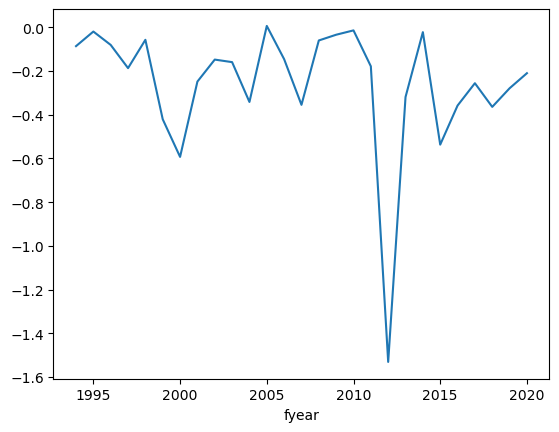

In [407]:
#6.	Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.
df_usa = filteredPublicFirms[filteredPublicFirms['location'] == 'USA']
df_usa['roa'] = df_usa['ni'] / df_usa['asset']
avg_return_on_assets = df_usa.groupby('fyear')['roa'].mean()
avg_return_on_assets.plot.line()

## Part 2. Text Analysis on the Industry Sector

### C. Text Cleaning

In [394]:
translator = str.maketrans('', '', string.punctuation)
sw = stopwords.words('english')

def clean_text(text):
    #1.	Convert all words to lowercase.
    clean_text = text.lower()

    #2.	Remove punctuations.
    clean_text = clean_text.translate(translator)

    #3.	Remove stop words based on the list of English stop words in NLTK.
    clean_words = [w for w in clean_text.split() if w not in sw]
    
    return ' '.join(clean_words)


### D. Keyword Analysis

In [397]:
#1.	Create a new DataFrame that includes only firms in your selected industry sectors. Ensure that you merge the 10-K data with the previous "public_firm.csv" data using an inner join.


In [398]:
#2.	Generate the top 10 keywords for each firm based on two different methods: word counts and TF-IDF score.


In [399]:
#3.	Create two wordclouds to visualize the keywords across all firms in the selected sector: one based on the word count of keywords and another based on the TF-IDF score.


### E. Word Embedding

In [400]:
#1.	Train a word2vec model with the full 10-K sample (e.g., "data/2020_10K_item1_full.csv"). Please use the cleaned text (e.g., results from Step C) for training.


In [401]:
#2.	Manually inspect the wordclouds you generated in D.3 and choose three representative keywords that are relevant to the industry sector of your interest. Utilize the trained word2vec model to find the most relevant five words for each of these three keywords.


## Part 3. Comprehensive Analysis of One Sample Firm

### F. Firm Analysis and Strategy Suggestion

In [402]:
#1.	Convert the keywords extracted in D.2 into word embeddings with the word2vec model trained in E.1. Add up the embeddings for each firm to create the firm-level embeddings. Use the firm-level embeddings to find the focal firm’s competing firms (or, most similar firms). 


In [403]:
#2.	Compare the revenue, market share, and ROA of the focal firm to its competitors and provide suggestions accordingly.


In [404]:
#3.	Perform an analysis of the historical stock prices, ROA, revenue, and assets of the chosen company. Investigate potential correlations and address noteworthy decreases and increases.
